In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model-2-2lstm/model_2_2lstm.h5
/kaggle/input/wcr-w2v-model/wcr_trigrams_300features_5minwords_20context (2).bin
/kaggle/input/wcr-preprocessed/wcr_preprocessed.csv
/kaggle/input/lstm-model-sa/LSTM_model_30epochs.h5


# Women's Clothing Reviews - Sentiment Analysis: Model Building

## Overall Project Goal
In this project I want to understand this dataset on women's clothing reviews, create a Word2Vec model based off of the review texts in the data set and then use this Word2Vec model to build a sentiment analysis model on the dataset which attempts to predict whether the customer left a 5-star review or not.

### Project Notebooks
This notebook is part of a series of 3 notebooks on performing sentiment analysis on a dataset of women's clothing reviews.
1. Women's Clothing Reviews - Sentiment Analysis: EDA **{ADD LINKS}**
2. Women's Clothing Reviews - Sentiment Analysis: Building Word2Vec Model
3. **Women's Clothing Reviews - Sentiment Analysis: Building a Sentiment Analysis Model**


## Goal of this notebook: Building Word2Vec Model
In this notebook I want to: vectorise the data, split it into test, train and validation sets and build our sentiment analysis model using an LSTM architecture to attempt to classify whether a customer left a 5-star review or not, using their review text.

## 1. Loading Libraries and Data

In [2]:
# Data manipulation tools
import numpy as np
import pandas as pd

# Data visualisation tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Tools for building a LSTM model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tool to load pretrained models
from keras.models import load_model

# Evaluating model performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# To load the pretrained word2vec model
from gensim.models import Word2Vec, Phrases
from gensim.models import KeyedVectors

In [3]:
# Loading the cleaned and preprocessed dataset
data = pd.read_csv('/kaggle/input/wcr-preprocessed/wcr_preprocessed.csv', usecols=['Five Star', 'Total Text', 'Rating'])

In [4]:
# Looking at the first 5 rows of the data
data.head()

,Five Star,Rating,Total Text
0,0,4,"['absolutely', 'wonderful', 'silky', 'sexy', '..."
1,1,5,"['love', 'dress', 'sooo', 'pretty', 'happen', ..."
2,0,3,"['major', 'design_flaw', 'high_hop', 'dress', ..."
3,1,5,"['favorite', 'buy', 'love', 'love', 'love', 'j..."
4,1,5,"['flatter', 'shirt', 'shirt', 'flatter', 'due'..."


Now we are left with a dataframe that only contains two columns. The `Five Star` column, which is the target variable and the `Total Text` column, which is a concatenation of the title and the main text of the review. The `Total Text` column has also been preprocessed: it has had html removed, non letters removed, been made lowercase, stopwords removed and lemmatized. It has then be formatted to be a list of lists.

## 2. Vectorising Data

In [5]:
# Finding the longest review to use number in padding later
longest_review = max([len(review.split()) for review in data['Total Text']])
print(f'The longest text used in the model has a length {longest_review}')

The longest text used in the model has a length 60


In [6]:
# Loading the pretrained Word2Vec language model
w2v_model = KeyedVectors.load_word2vec_format('/kaggle/input/wcr-w2v-model/wcr_trigrams_300features_5minwords_20context (2).bin', binary=True)

In [7]:
%%time
def vectorize_data(X_data, vocab):
    
    # This function takes in text data in the format of a review being broken down into a list 
    # of tokens, and a our vocab dictionary from the word2vec model we previously trained. It
    # outputs the reviews broken down into a list indexes which refer to the vectors trained by the w2v model
    
    
    print('Vectorizing sentences...')
    
    # Get the keys from the vocab dictionary
    keys = list(vocab.keys())
    
    # Define a function to check if a word is in the vocab
    def is_known(word):
        return word in keys
    
    # Define a function to encode a review by mapping each word to its index in the vocab
    def encode_review(review):
        return [keys.index(word) for word in review if is_known(word)]
    
    # Vectorize each review in the data using the encode_review function
    vectorized_data = [encode_review(review) for review in X_data]
    
    print('Vectorizing sentences... Done')
    return vectorized_data


# This is padding the reviews so that they all have the same length
input_length = longest_review
X_pad = pad_sequences(
    sequences=vectorize_data(data['Total Text'], vocab=w2v_model.key_to_index),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Vectorizing sentences...
Vectorizing sentences... Done
Transform sentences to sequences... (done)
CPU times: user 6min 58s, sys: 214 ms, total: 6min 58s
Wall time: 6min 58s


## 3. Splitting Data into Train, Test and Validation Sets

In [8]:
# Splitting the target variable and the text
X_data = X_pad
y_data = data['Five Star']

In [9]:
# Split data into train and test sets (70% for training and 30% for testing)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

# Split the test set into test and validation sets (50% each)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Training set length: ", len(X_train))
print("Validation set length: ", len(X_val))
print("Test set length: ", len(X_test))

Training set length:  15848
Validation set length:  3397
Test set length:  3396


## 4. Building LSTM Sentiment Analysis Model

### 4.1

In [10]:
def build_model_simple(embedding_matrix: np.ndarray, input_length: int, random_seed: int = 42):
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Set up the model
    model_simple = Sequential()

    # Add an embedding layer to convert integer inputs to dense vectors
    model_simple.add(Embedding(
            input_dim = embedding_matrix.shape[0],
            output_dim = embedding_matrix.shape[1], 
            input_length = input_length,
            weights = [embedding_matrix],
            trainable=False))

    # Add a single LSTM layer with 128 units
    model_simple.add(LSTM(units=128, dropout=0.15))

    # Add a dense output layer with sigmoid activation for binary classification
    model_simple.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Print a summary of the model
    model_simple.summary()

    return model_simple


model_simple = build_model_simple(w2v_model.vectors, input_length)

# Compile the model
model_simple.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

# Add early stop to stop training if val loss stops changing
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Fit the model to the data
history_simple = model_simple.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=100,
    epochs=30, 
    callbacks=[early_stop])

# Saving the trainined model
model_simple.save('model_simple_lstm128.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 300)           1587300   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,807,077
Trainable params: 219,777
Non-trainable params: 1,587,300
_________________________________________________________________
Epoch 1/30
159/159 [==============================] - 26s 148ms/step - loss: 0.6859 - accuracy: 0.5530 - val_loss: 0.6859 - val_accuracy: 0.5573
Epoch 2/30
159/159 [==============================] - 23s 147ms/step - loss: 0.6838 - accuracy: 0.5627 - val_loss: 0.6853 - val_accuracy: 0.5628
Epoch 3/30
159

In [11]:
# Make predictions on the test data
y_test_preds = model_simple.predict(X_test)
y_test_preds = (y_test_preds > 0.5).astype(int)
test_accuracy_model_simp = accuracy_score(y_test, y_test_preds)

print(f'The simple LSTM model has an accuracy score on the test set of {test_accuracy_model_simp:.3f}')

107/107 [==============================] - 4s 32ms/step
The simple LSTM model has an accuracy score on the test set of 0.691


In [12]:
# Calculating precision, recall and f1
precision_simp = precision_score(y_test, y_test_preds)
recall_simp = recall_score(y_test, y_test_preds)
f1_simp = f1_score(y_test, y_test_preds)

print(f'The simple model has a precision score of {precision_simp:.3f}, recall of {recall_simp:.3f}, and f1 of {f1_simp:.3f}')

The simple model has a precision score of 0.725, recall of 0.734, and f1 of 0.729


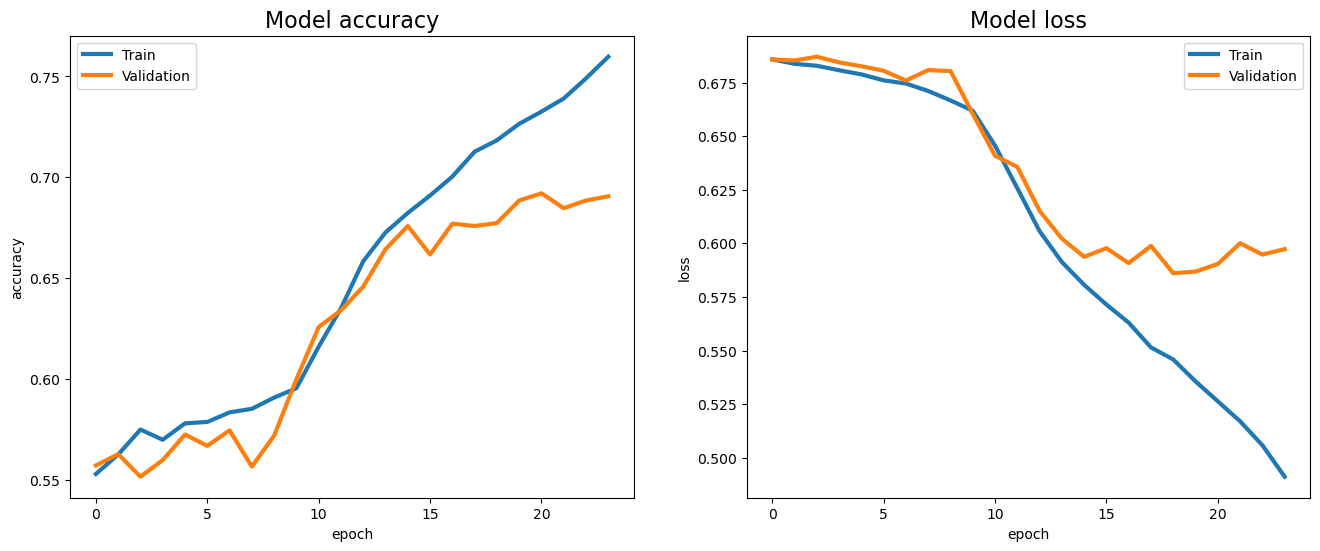

In [13]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history_simple.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history_simple.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history_simple.history['loss'], label='Train', linewidth=3)
axis2.plot(history_simple.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

### 4.2

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

def build_model_2(embedding_matrix: np.ndarray, input_length: int, random_seed: int = 42):
    tf.random.set_seed(random_seed)
    model_2 = Sequential()
    model_2.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model_2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model_2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model_2.add(Dense(1, activation='sigmoid'))
    model_2.summary()
    return model_2

# Build the model using the w2v vectors
model_2 = build_model_2(
    embedding_matrix=w2v_model.vectors,
    input_length=input_length,
    random_seed=42)

# Compile the model
model_2.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

# Add early stop to stop training if val loss stops changing
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Fit the model to the data
history_2 = model_2.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=100,
    epochs=35, 
    callbacks=[early_stop])

# Saving the trainined model
model_2.save('model_2_2lstm.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 300)           1587300   
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           219648    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,856,421
Trainable params: 269,121
Non-trainable params: 1,587,300
_________________________________________________________________
Epoch 1/35
159/159 [==============================] - 67s 379ms/step - loss: 0.6872 - accuracy: 0.5499 - val_loss: 0.6870 - val_accuracy: 0.5499
Epoch 2/35
159/159 [=====

In [15]:
model_2 = load_model('/kaggle/input/lstm-model-sa/LSTM_model_30epochs.h5')

In [16]:
# Make predictions on the test data
y_test_preds = model_2.predict(X_test)
y_test_preds = (y_test_preds > 0.5).astype(int)
test_accuracy_model_2 = accuracy_score(y_test, y_test_preds)

print(f'The model_2 with 2 LSTM layers has an accuracy score on the test set of {test_accuracy_model_2:.3f}')

107/107 [==============================] - 4s 35ms/step
The model_2 with 2 LSTM layers has an accuracy score on the test set of 0.691


In [17]:
# Calculating precision, recall and f1
precision_2 = precision_score(y_test, y_test_preds)
recall_2 = recall_score(y_test, y_test_preds)
f1_2 = f1_score(y_test, y_test_preds)

print(f'The model_2 has a precision score of {precision_2:.3f}, recall of {recall_2:.3f}, and f1 of {f1_2:.3f}')

The model_2 has a precision score of 0.686, recall of 0.839, and f1 of 0.755


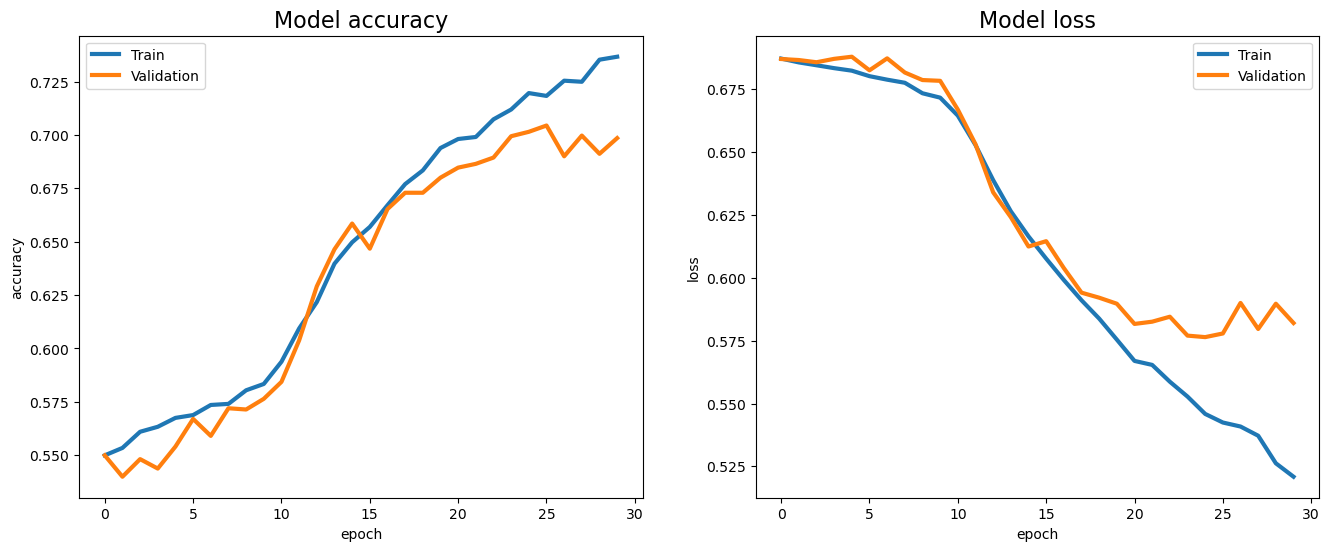

In [18]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history_2.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history_2.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history_2.history['loss'], label='Train', linewidth=3)
axis2.plot(history_2.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

### 4.3

In [19]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Instantiate the model
def build_model(embedding_matrix: np.ndarray, input_length: int, random_seed: int = 42):
    tf.random.set_seed(random_seed)
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

# Build the model using the w2v vectors
model_3 = build_model(
    embedding_matrix=w2v_model.vectors,
    input_length=input_length,
    random_seed=42)

# Compile the model
model_3.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

# Add early stop to stop training if val loss stops changing
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Fit the model to the data
history_3 = model_3.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=100,
    epochs=30, 
    callbacks=[early_stop])

# Saving the trainined model
model_3.save('LSTM_model_30epochs.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 300)           1587300   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [20]:
# Load the model from the .h5 file
# model = load_model('/kaggle/input/lstm-model-sa/LSTM_model_30epochs.h5')

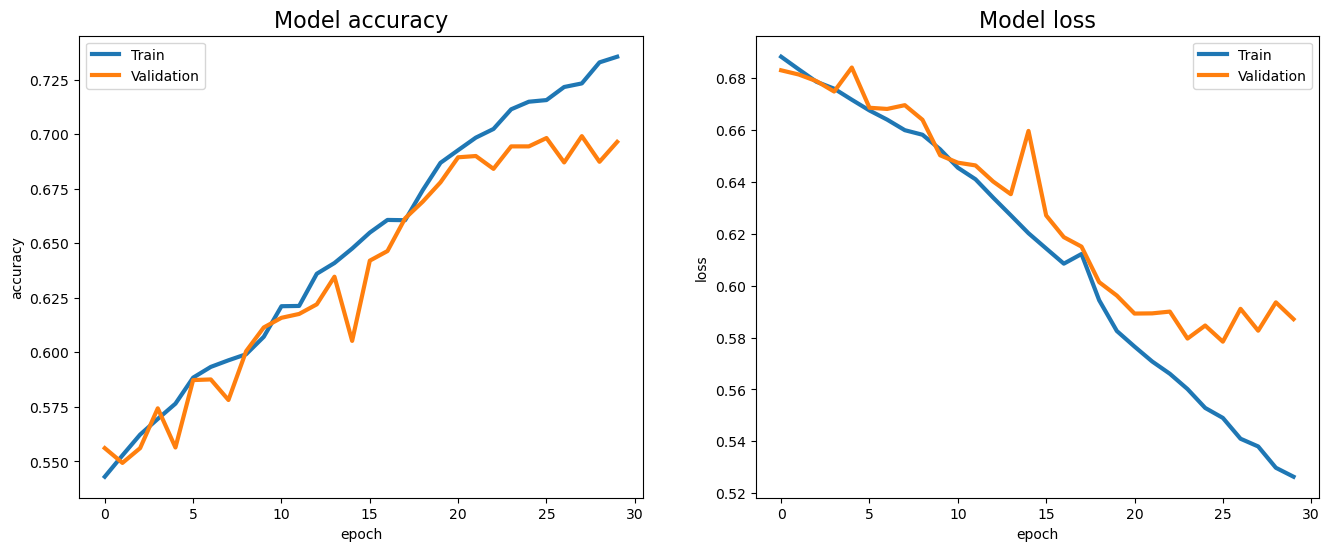

In [21]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history_3.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history_3.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history_3.history['loss'], label='Train', linewidth=3)
axis2.plot(history_3.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [22]:
# Make predictions on the test data
y_test_preds = model_3.predict(X_test)
y_test_preds = (y_test_preds > 0.5).astype(int)
test_accuracy_model_3 = accuracy_score(y_test, y_test_preds)

print(f'The accuracy score on the test set is {test_accuracy_model_3:.3f}')

107/107 [==============================] - 4s 34ms/step
The accuracy score on the test set is 0.702


In [23]:
# Calculating precision, recall and f1
precision_3 = precision_score(y_test, y_test_preds)
recall_3 = recall_score(y_test, y_test_preds)
f1_3 = f1_score(y_test, y_test_preds)

print(f'On the test set, model_3 has a precision score of {precision_3:.3f}, recall of {recall_3:.3f}, and f1 of {f1_3:.3f}')

On the test set, model_3 has a precision score of 0.710, recall of 0.801, and f1 of 0.753


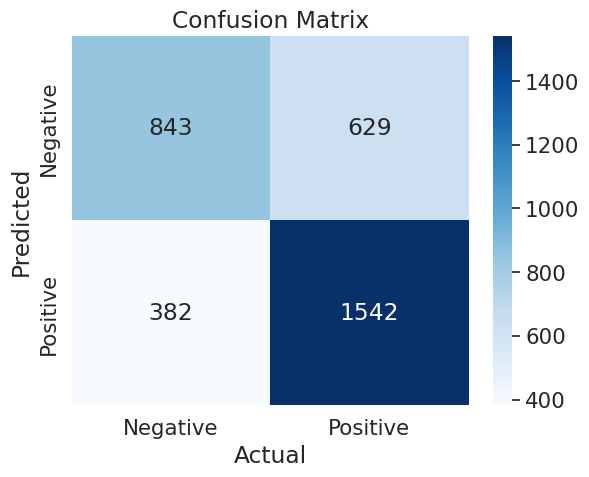

In [24]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_preds)
labels = ['Negative', 'Positive']

# Create a heatmap using Seaborn
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')

plt.show()


**Observations**:
- Precision: The precision score of 0.686 indicates that out of all the instances that the model predicted as positive, only 68.6% were actually positive. In other words, there were quite a few false positives.

- Recall: The recall score of 0.839 indicates that out of all the actual positive instances in the data, the model was able to correctly identify 83.9% of them. In other words, the model has a relatively high ability to correctly identify positive instances.

- F1 Score: The F1 score of 0.755 is the harmonic mean of precision and recall, and provides a balance between these two metrics. It is a single score that represents the overall performance of the model, and it indicates that the model is relatively good at balancing precision and recall.

Let's compare the predictions against the ratings given for the test set.

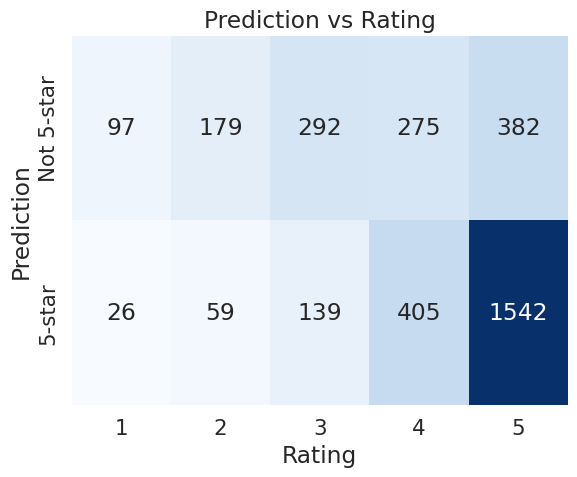

In [25]:
# Adding predictions to a dataframe that is just the test set
test_rows = data.loc[y_test.index]
test_rows['Prediction'] = y_test_preds
test_rows.head()

# Create a cross-tabulation table
ct = pd.crosstab(test_rows['Prediction'], test_rows['Rating'])
ct = ct.rename(index={1:'5-star', 0:'Not 5-star'})

# Create the heatmap
sns.heatmap(ct, cmap='Blues', annot=True, fmt='d', cbar=False)

# Set the axis labels and title
plt.xlabel('Rating')
plt.ylabel('Prediction')
plt.title('Prediction vs Rating')
plt.show()


**Observations:**
- We can see that there wre 35 1-star ratings and 78 2-star ratings that the model predicted were 5-star. We will investigate some of these cases further to look at the text.
- Also we can see that there were 310 5-star ratings that the model predicted were not 5-star. We will have a look at these examples too.
- 74% of the incorrect predictions come from 5-star reviews that were predicted not the be 5-star (30% of errors), or 4-star reviews that were predicted to be 5-star reviews (34% of errors).

In [26]:
# Adjusting settings to see full text
pd.options.display.max_colwidth = 500

# Looking at rows that had a rating of 1-star, but the model predicted 5-star
test_rows[(test_rows['Rating'] == 1) & (test_rows['Prediction'] == 1)][:4]

,Five Star,Rating,Total Text,Prediction
1704,0,1,"['like', 'photo', 'think', 'picture', 'would', 'light', 'floaty', 'top', 'arrive', 'fabric', 'heavy', 'knit', 'neckline', 'sag', 'low', 'grant', 'pear', 'bottom', 'layer', 'hug', 'tummy', 'rear', 'unflattering', 'way', 'thing', 'like', 'color', 'back', 'go']",1
4489,0,1,"['fit', 'really', 'excite', 'get', 'dress', 'initially', 'order', 'small', 'size', 'try', 'really', 'tight', 'bodice', 'top', 'fit', 'strangely', 'shorten', 'strap', 'quite', 'bite', 'dress', 'look', 'love', 'retailer', 'get', 'dress', 'look', 'dress', 'line', 'beautiful', 'fit', 'right', 'love', 'lace', 'look', 'would', 'love', 'see', 'dress', 'design']",1
4296,0,1,"['sleeves', 'dealbreaker', 'literally', 'unflattering', 'thing', 'ever', 'try', 'retailer', 'sleeves', 'weird', 'ugly', 'get', 'really', 'fat', 'top', 'like', 'dolman_sleeve', 'look', 'really', 'strange', 'flow', 'rest', 'top', 'structure', 'make', 'shoulder', 'look', 'huge', 'even_though', 'narrow_shoulder', 'apparent', 'model', 'picture', 'thick', 'black', 'seam', 'shoulder', 'also', 'place', 'really', 'awkward', 'spot', 'also', 'contri']",1
19432,0,1,"['cute', 'style', 'shirt', 'overpower', 'vinegar', 'odor', 'take_package', 'mint_green', 'color', 'appeal', 'style', 'look', 'good', 'smell', 'much']",1


**Observations**:
- On some of these examples it is easy to see how the model might think the review is positive. For example in the second review above there are words like: 'excite', 'love' (features 3 times in this review), 'beautiful'. There were 'negative' words present but it isn't obvious that this was a 1-star review.
- On the 4th review above (index 19432) the customer clearly had an issue with the smell of the package. We can see why the model did perform well in this case as it probably didn't train enough on reviews that referred to the smell.
- On some cases it just seems the model performs poorly, the review clearly is not a 5-star review.

In [27]:
# Looking at rows that had a rating of 5-star, but the model predicted not 5-star
test_rows[(test_rows['Rating'] == 5) & (test_rows['Prediction'] == 0)][:5]

,Five Star,Rating,Total Text,Prediction
3187,1,5,"['unique', 'pretty', 'top', 'pretty', 'would', 'say', 'probably', 'size', 'smaller', 'normal', 'like', 'crop', 'fit']",0
14546,1,5,"['pretty', 'top', 'top', 'really', 'beautiful', 'lace_detail', 'color', 'much', 'deeper', 'pink', 'picture', 'online', 'order', 'xs', 'petite', 'fit', 'fine', 'like', 'top', 'longer', 'wish', 'get', 'regular', 'xs', 'instead', 'pretty']",0
18995,1,5,"['love', 'skirt', 'feel', 'love', 'store', 'stop', 'think', 'weeks', 'later', 'know', 'get', 'beautifully', 'make', 'high_quality', 'materials', 'flatter', 'fit', 'well', 'figure', 'big', 'butt', 'hips', 'w', 'small', 'waist', 'sit', 'belly_button', 'accentuate_waist', 'slim_hips', 'must']",0
17431,1,5,"['cool', 'really', 'adorable', 'retro', 'look', 'fit', 'true_size', 'get', 'size', 'larger', 'want', 'tie', 'bottom', 'days', 'wear', 'twice_already']",0
8565,1,5,"['love', 'know', 'bite', 'moot', 'point', 'since', 'chemise', 'sell', 'chance', 'come', 'back', 'stock', 'see', 'one', 'local_store', 'urge', 'try', 'fabric', 'incredible', 'luxurious', 'fit', 'amazingly', 'hard_time', 'whole', 'tight', 'chemise', 'slip', 'nightie', 'category', 'clothe', 'fairly', 'skinny', 'still', 'curvy', 'love', 'curve', 'muffin_top', 'get', 'real', 'awkward', 'try', 'look', 'sexy', 'however', 'godsend']",0


**Observations:**
- Perhaps they didn't seem positive enough to the model to be classified as 5-star. Because 4-star reviews would contain positive sentiment, to be classified as 5-star the review must be very positive. Indeed, as we would expect, the model found it hard to classify all 5-star reviews correctly and it incorrectly classified lots of 4-star reviews as 5-star reviews. We would imagine that a human making predictions would similarly struggle to differentiate these two categories.


## 5. Conclusion

After performing EDA on the dataset, it was observed that a rating less than 5-stars did not necessarily mean that the customer did not like the product. For example lots of customers that even gave the product a 3-Star rating also said that they would recommend the product to someone else. As a result, the model identified a significant number of false positives. 

Though using 5-star rating as a target variable made sense from a business perspective, the split of 55%/45% for 5-star and non 5-star reviews did not match the sentiment split of the dataset, thus making it a difficult task for the model to have a high accuracy. From a business perspective, going forward it might be useful to try to understand why some customers leave a positive text review but do not give the item a 5-star review. This could help improve customer experience and ensure that ratings reflect only the customer's opinion on the item they purchased, as opposed to their opinion on the delivery time or customer service etc.

**TL;DR**: A customer rating of less than 5-stars did not always indicate customer dissatisfaction. The model had significant false positives. Though the dataset was balanced, it did not match the sentiment split of the dataset. The company should focus on understanding why customers leave a positive text review but not give a 5-star rating to improve customer experience.

In [28]:
results = pd.DataFrame(
    [[test_accuracy_model_simp, precision_simp, recall_simp, f1_simp],[test_accuracy_model_2, precision_2, recall_2, f1_2], [test_accuracy_model_3, precision_3, recall_3, f1_3]], 
    columns=['Accuracy', 'Precision', 'Recall', 'F1 score'],
    index=['Simple model', 'Model 2', 'Model 3']
)

In [29]:
results

,Accuracy,Precision,Recall,F1 score
Simple model,0.691402,0.724846,0.733888,0.729339
Model 2,0.691402,0.686224,0.838877,0.754911
Model 3,0.702297,0.710272,0.801455,0.753114


## Project Extensions

- Use a pretrained Word2Vec model on the dataset and compare performance.
- Train on more data.

# Todo
- Add a conclusion section that summarises what I have done in the project and summarises the results
       